# Проведение A/B-теста для принятия решения о внедрении функционала по вычислению мошенников на маркетплейсе

Распространённая и самая известная на рынке схема мошенничества: мошенник берёт данные ИНН из открытых источников, регистрирует на него компанию на площадке маркетплейса. Далее выставляет ходовой товар на продажу, например iPhone 14, на 50% дешевле рынка. Когда покупатель оформляет заказ на маркетплейсе, продавец пишет покупателю, что у него есть другой сайт, где можно купить товар ещё дешевле. Покупатель соглашается и оплачивает заказ по ссылке продавца в обход площадки. После этого продавец пропадает. Покупатель остается без товара. Такие продавцы очень сильно портят репутацию маркетплейса, и необходимо их выявлять как можно быстрее, лучше всего в процессе регистрации.

Для этого ML-команда предложила к использованию модель по автоопределению продавцов-мошенников, которую предлагается внедрить в процесс регистрации продавца.

Необходимо провести A/B-тест, чтобы проверить качества новой модели.

Необходимо ответить на следующие **вопросы**:

1. Как определить, какой продавец мошенник, а какой — нет? Какие ещё могут быть схемы мошенничества?

2. Какие продуктовые фичи могут помочь клиентам избежать неприятных ситуаций с мошенничеством?

3. Через какую механику мошенник узнает контакты покупателя? Что можно сделать, чтобы усложнить жизнь фродерам?

Также необходимо описать методологию и дизайн теста. Почему сделан такой выбор?

1. Определить основную метрику (дополнительные метрики) и принцип разделения на группы.

2. Рассчитать, какой эффект можно статистически значимо отследить.


## Содержание

Подготовка данных

Анализ признаков

Ответы на продуктовые вопросы

Дизайн теста

## Подготовка данных

Импорт библиотек, которые потребуются для выполнения исследования, и загрузка датасета:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mth
from scipy import stats
import statsmodels.stats.power as smp

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('fraud.csv', sep=';')

Посмотрим на данные в первом приближении:

In [ ]:
df.head()

,registration_date,activation_date,merchant_id,type,ind_frod
0,16.12.2023,24.12.2023,1,IE,0.0
1,05.09.2023,08.09.2023,2,IE,0.0
2,16.04.2023,22.04.2023,3,IE,0.0
3,23.12.2023,24.12.2023,4,IE,0.0
4,28.01.2023,NaN,5,IE,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   registration_date  35000 non-null  object 
 1   activation_date    20300 non-null  object 
 2   merchant_id        35000 non-null  int64  
 3   type               35000 non-null  object 
 4   ind_frod           34300 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


Названия признаков:
  - **registration_date** - дата регистрации (дата получения merchant_id, продавец зарегистрировался на площадке);
  - **activation_date** - дата активации (продавец прошел все этапы регистрации и может продавать);
  - **merchant_id** - id продавца;
  - **type** - форма организации бизнеса (IE - индивидуальный предприниматель, LLC - общество с ограниченной ответственностью);
  - **ind_frod** - индекс мошенника (1- мошенник, 0 - добросовестный продавец).

В датасете содержатся данные о 35000 продавцах и 5 признаках. В столбцах **activation_date** и **ind_frod** есть пропуски.

Полных дубликатов в датафрейме нет:

In [ ]:
df.duplicated().sum()

0

## Анализ признаков

Теперь рассмотрим признаки по отдельности.

**merchant_id** - id продавца

In [ ]:
df['merchant_id'].nunique()

35000

Дубликаты id в столбце отсутствуют.

**registration_date** - дата регистрации

Приведем к временному типу:

In [ ]:
df['registration_date'] = pd.to_datetime(df['registration_date'],format='%d.%m.%Y')

In [ ]:
df['registration_date'].agg(['min','max'])

min   1970-01-01
max   2023-12-31
Name: registration_date, dtype: datetime64[ns]

В датафрейме встречается неожиданное временное значение - 01.01.1970. Вероятно, по таким клиентам информация о дате регистрации отсуствует (если в поле даты хранится целочисленный ноль, то подтягивается значение '1970-01-01'). Вообще говоря, Мегамаркет был создан на базе платформы Goods.ru в 2017 году, поэтому в базе не должно быть никаких клиентов с датой регистрации ранее 2017 года. Проверим, есть ли такие:

In [ ]:
df.query('registration_date < "2017-01-01"')['merchant_id'].count()

175

Таких клиентов 175 человек (0,5% датасета). Посмотрим, сколько среди них мошенников:

In [ ]:
df.query('registration_date < "2017-01-01" & ind_frod == 1')['merchant_id'].count()

14

In [ ]:
df.query('ind_frod == 1')['merchant_id'].count()

2828

Всего мошенников в датасете 2828, так что удаление записей с некорректной датой регистрации не должно повлиять на дальнейшие выводы.

In [ ]:
df = df.loc[(df['registration_date'] != "1970-01-01")]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34825 entries, 0 to 34999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   registration_date  34825 non-null  datetime64[ns]
 1   activation_date    20214 non-null  object        
 2   merchant_id        34825 non-null  int64         
 3   type               34825 non-null  object        
 4   ind_frod           34127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
df['registration_date'].agg(['min','max'])

min   2023-01-02
max   2023-12-31
Name: registration_date, dtype: datetime64[ns]

Основная масса клиентов регистрировалась с 02.01.2023 по 31.12.2023.

In [ ]:
n_reg = df.groupby('registration_date').agg({'merchant_id':'nunique'}).reset_index().rename(columns = {'merchant_id': 'n'})

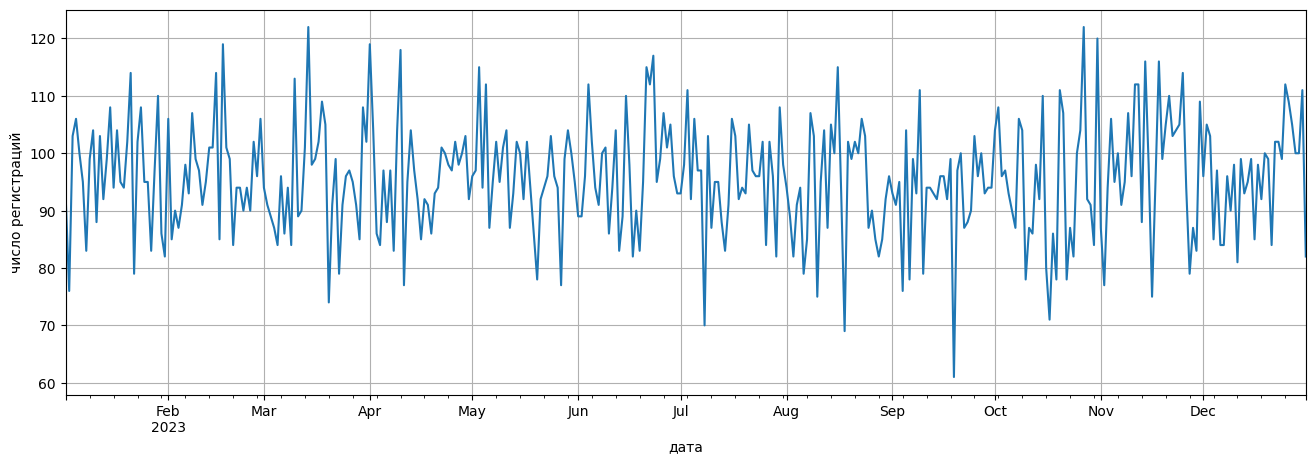

In [ ]:
n_reg.plot(x='registration_date', y='n', grid=True, figsize=(16,5), legend=False)
plt.xlabel('дата')
plt.ylabel('число регистраций')
plt.show()

In [ ]:
n_reg['n'].agg(['mean','median'])

mean      95.673077
median    96.000000
Name: n, dtype: float64

Как правило, в день регистрируется от 80 до 110 пользователей, среднее практически совпадает с медианой - 96 человек.

Выделим в исходном датафрейме в отдельные столбцы год, месяц и неделю, а также день недели:

In [ ]:
df['reg_month'] = df['registration_date'].dt.month
df['reg_weekday'] = df['registration_date'].dt.weekday
display(df.head())

,registration_date,activation_date,merchant_id,type,ind_frod,reg_month,reg_weekday
0,2023-12-16,24.12.2023,1,IE,0.0,12,5
1,2023-09-05,08.09.2023,2,IE,0.0,9,1
2,2023-04-16,22.04.2023,3,IE,0.0,4,6
3,2023-12-23,24.12.2023,4,IE,0.0,12,5
4,2023-01-28,NaN,5,IE,0.0,1,5


In [ ]:
reg_per_month = df.groupby('reg_month').agg({'merchant_id': 'nunique'}).reset_index().rename(columns={'merchant_id': 'n'})

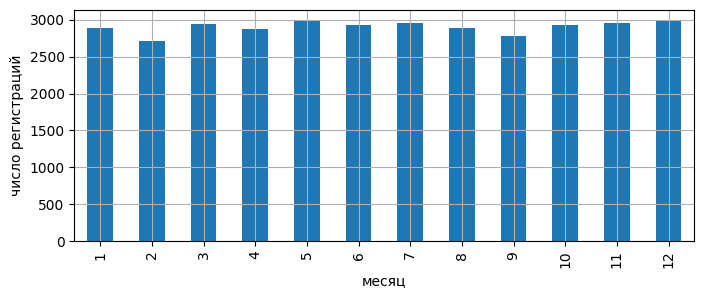

In [ ]:
reg_per_month.plot(x='reg_month', y='n', kind='bar', grid=True, figsize=(8,3), legend=False)
plt.xlabel('месяц')
plt.ylabel('число регистраций')
plt.show()

Каждый месяц регистрировалось примерно одинаковое число продавцов. Немного меньшее значение было в феврале, что, вероятно, связано с тем, что месяц короткий.

In [ ]:
reg_per_weekday = df.groupby('reg_weekday').agg({'merchant_id': 'nunique'}).reset_index().rename(columns={'merchant_id': 'n'})

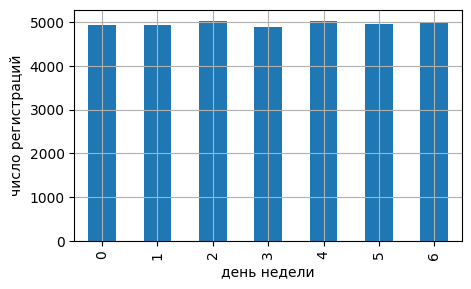

In [ ]:
reg_per_weekday.plot(x='reg_weekday', y='n', kind='bar', grid=True, figsize=(5,3), legend=False)
plt.xlabel('день недели')
plt.ylabel('число регистраций')
plt.show()

Число регистраций не зависит от дня недели.

**activation_date** - дата активации

In [ ]:
df['activation_date'] = pd.to_datetime(df['activation_date'],format='%d.%m.%Y')

In [ ]:
df['activation_date'].agg(['min','max'])

min   2022-01-22
max   2024-08-30
Name: activation_date, dtype: datetime64[ns]

Период имеющихся значений - от 22.01.2022 до 30.08.2024. Это любопытно. Во-первых, если не считать 175 клиентов с неустановленной датой регистрации, которых мы уже удалили из датасета, все регистрации совершались в 2023 году. Во-вторых, у некоторых клиентов период от регистрации до активации занял продолжительное время - не менее 8 месяцев, т.к. все регистрации совершены в 2023 году.

Также помним, что в этой колонке заполнено всего 20 300 строк из 35 000 исходных. Клиенты без даты активации либо были определены как мошенники и не получили возможность пользоваться сервисом, либо так и не начали работать на платформе.

Проверим, сколько активаций было совершено до 02.01.2023:

In [ ]:
df.query('activation_date < "2023-01-02"')['merchant_id'].count()

5

Таких записей всего 5. Оптимльнее всего просто удалить их из датасета. Вместе с этим стоит отдельно (вне рамок А/B-тестирования) рассмотреть этих пользователей и определить, ошибка ли это в данных датасета или есть неочевидный механизм активировать учетную запись до регистрации.

Посмотрим, есть ли еще подобные пользователи, укладывающиеся в рассматриваемый диапазон:

In [ ]:
df.query('activation_date < registration_date')['merchant_id'].count()

19

In [ ]:
df.query('activation_date < registration_date').head()

,registration_date,activation_date,merchant_id,type,ind_frod,reg_month,reg_weekday
16,2023-09-21,2023-08-27,17,IE,1.0,9,3
223,2023-07-02,2023-05-11,224,IE,0.0,7,6
670,2023-11-23,2023-11-04,671,IE,0.0,11,3
1007,2023-05-26,2022-06-03,1008,IE,0.0,5,4
1829,2023-05-24,2023-05-21,1830,IE,0.0,5,2


Такие пользователи есть. Их по-прежнему немного, поэтому удалим их из датасета.

In [ ]:
df = df.loc[(df['activation_date'] >= df['registration_date']) | (df['activation_date'].isna())]

In [ ]:
df.shape[0]

34806

Избавимся от пропусков, заменив их на неправдоподобно большую дату в будущем.

In [ ]:
df['activation_date'] = df['activation_date'].fillna('2200-01-01')
df['activation_date'] = pd.to_datetime(df['activation_date'],format='%d.%m.%Y')

Добавим новый столбец, который показывает число дней, прошедших от даты регистрации до даты активации:

In [ ]:
df['reg_duration'] = (df['activation_date'] - df['registration_date']).dt.days

In [ ]:
df.head()

,registration_date,activation_date,merchant_id,type,ind_frod,reg_month,reg_weekday,reg_duration
0,2023-12-16,2023-12-24,1,IE,0.0,12,5,8
1,2023-09-05,2023-09-08,2,IE,0.0,9,1,3
2,2023-04-16,2023-04-22,3,IE,0.0,4,6,6
3,2023-12-23,2023-12-24,4,IE,0.0,12,5,1
4,2023-01-28,2200-01-01,5,IE,0.0,1,5,64621


Посмотрим на распределение распределние новой переменной, убрав часть датасета, где реальная дата активации отсутствует:

In [ ]:
act_date_not_null = df.query('activation_date != "2200-01-01"')

In [ ]:
act_date_not_null['reg_duration'].describe()

count    20195.000000
mean         6.023570
std          4.075406
min          1.000000
25%          3.000000
50%          6.000000
75%          9.000000
max        373.000000
Name: reg_duration, dtype: float64

Посмотрим, сколько выбросов в распределении. Выбросами по определению будем считть наблюдения, выходящие за 1,5 межквартильных размаха.

In [ ]:
q1 = act_date_not_null['reg_duration'].quantile(q=0.25)
q3 = act_date_not_null['reg_duration'].quantile(q=0.75)
iqr = q3 - q1

In [ ]:
outliers = act_date_not_null.loc[(act_date_not_null['reg_duration'] < q1 - 1.5 * iqr) |
                                 (act_date_not_null['reg_duration'] > q3 + 1.5 * iqr)]

In [ ]:
outliers

,registration_date,activation_date,merchant_id,type,ind_frod,reg_month,reg_weekday,reg_duration
34890,2023-08-23,2024-08-30,34891,LLC,0.0,8,2,373


Всего один выброс: продавец был активирован через 383 дня после регистрации.

Посмотрим на распределение без выбросов:

In [ ]:
reg_dur_norm = act_date_not_null.query('merchant_id not in @outliers.merchant_id')
reg_dur_norm['reg_duration'].describe()

count    20194.000000
mean         6.005398
std          3.152808
min          1.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         11.000000
Name: reg_duration, dtype: float64

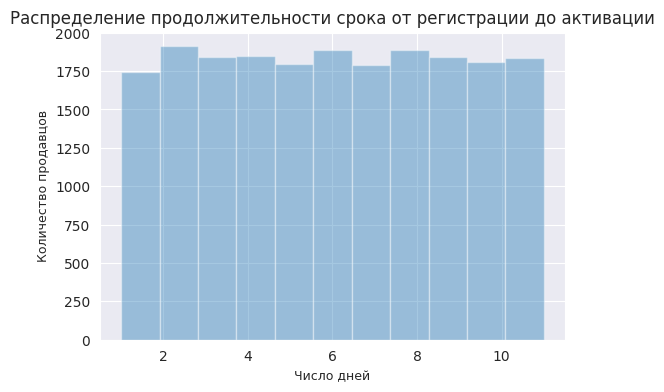

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(6, 4))
fig = sns.distplot(reg_dur_norm['reg_duration'], kde=False, bins = np.linspace(start=1, stop=11, num=12))
fig.set_title("Распределение продолжительности срока от регистрации до активации", fontsize=12)
fig.set_xlabel("Число дней", fontsize=9)
fig.set_ylabel("Количество продавцов", fontsize=9)
plt.show()

Количество продавцов в каждой группе примерно одинаковое. Среднее и медиана совпадают - 6 дней.

**type** - форма организации бизнеса

In [ ]:
display(df['type'].value_counts())
display(df['type'].value_counts(normalize = True))

type
IE     25079
LLC     9727
Name: count, dtype: int64

type
IE     0.720537
LLC    0.279463
Name: proportion, dtype: float64

72% продавцов оформлены как индиивидуальные предприниматели, 28% - как общество с ограниченной ответственностью.

**ind_frod** - индекс мошенника

По условию задания, индекс проставлялся либо вручную на этапе проверки документов, либо после на основе жалоб пользователей.

In [ ]:
display(df['ind_frod'].value_counts())
display(df['ind_frod'].value_counts(normalize = True))

ind_frod
0.0    31298
1.0     2810
Name: count, dtype: int64

ind_frod
0.0    0.917615
1.0    0.082385
Name: proportion, dtype: float64

Как мы помним, в столбце 700 пропущенных значений.

Доля продавцов-мошенников среди оставшхся записей - 8,2%. Добросовестных продавцов - 91,8%.

Вообще говоря, 700 записей без целевого признака не помогут нам в дальнейшем анализе, поэтому удалим их. Это 2% датасета.

In [ ]:
df = df.query('~ ind_frod.isna()')

Рассмотрим признаки в разрезе целевой переменной.

In [ ]:
fraud = df.query('ind_frod == 1')
nonfraud = df.query('ind_frod == 0')

Проверим, будет ли доля мошенников среди ИП выше, чем среди ООО.

In [ ]:
#вспомогательная функция для отображения процентов на графике
#принимает на вход название графика, сдвиг надписи по горизонтали и по вертикали

def show_percent(figure, shift, height):
    totals = []
    for i in figure.patches:
        totals.append(i.get_height())

    total = sum(totals)

    for i in figure.patches:
        figure.text(i.get_x() + shift, i.get_height() + height, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=8, color='black')

In [ ]:
type_f = fraud.groupby(by='type').agg({'merchant_id': 'count'}).reset_index().rename(columns = {'merchant_id': 'n'})
type_nf = nonfraud.groupby(by='type').agg({'merchant_id': 'count'}).reset_index().rename(columns = {'merchant_id': 'n'})

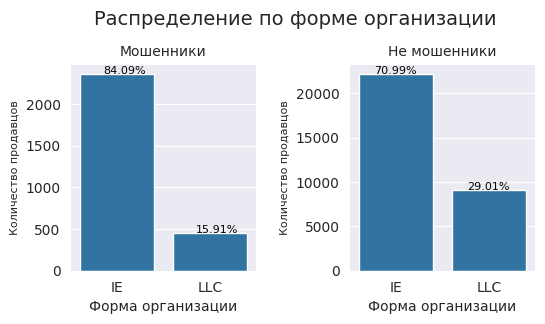

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по форме организации', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="type", y="n", data=type_f)
fig1.set_title("Мошенники", fontsize=10)
fig1.set_ylabel("Количество продавцов", fontsize=8)
fig1.set_xlabel("Форма организации")
show_percent(fig1, 0.25, 3)

fig2 = sns.barplot(ax=axes[1], x="type", y="n", data=type_nf)
fig2.set_title("Не мошенники", fontsize=10)
fig2.set_ylabel("Количество продавцов", fontsize=8)
fig2.set_xlabel("Форма организации")
show_percent(fig2, 0.17, 25)

plt.show()

Доля мошенников среди ИП действительно выше: 84% против 71%.

Теперь сравним группы относительно продолжительности регистрации. Сначала сделаем это по той части датасета, где изначально были указаны обе даты.

In [ ]:
act_date_not_null = df.query('activation_date != "2200-01-01"')
fraud_a = act_date_not_null.query('ind_frod == 1 and merchant_id not in @outliers.merchant_id')
nonfraud_a = act_date_not_null.query('ind_frod == 0 and merchant_id not in @outliers.merchant_id')

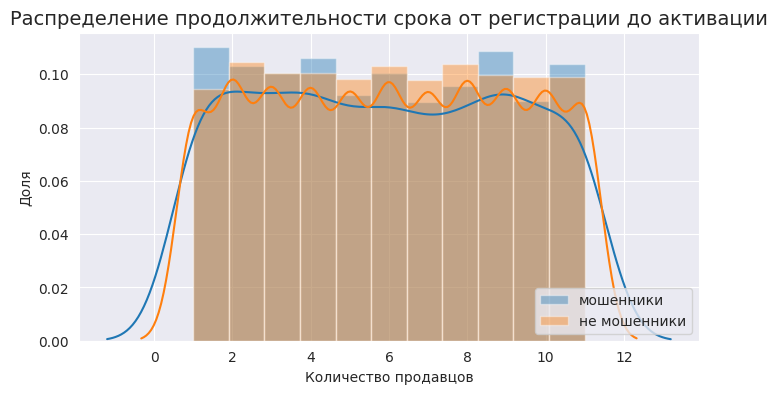

In [ ]:
plt.figure(figsize=(8, 4))
fig1 = sns.distplot(fraud_a['reg_duration'], kde=True, bins=np.linspace(start=1, stop=11, num=12), label='мошенники')
fig2 = sns.distplot(nonfraud_a['reg_duration'], kde=True, bins = np.linspace(start=1, stop=11, num=12), label='не мошенники')
fig2.set_title("Распределение продолжительности срока от регистрации до активации", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Количество продавцов")
plt.legend(loc='lower right')
plt.show()

In [ ]:
display(fraud_a['reg_duration'].mean())
display(nonfraud_a['reg_duration'].mean())

5.925578486554096

6.003901742045392

**Нулевая гипотеза**: "Среднее количество дней от регистрации до активации у продавцов-мошенников и добросовестных продавцов не различается".

**Альтернативная гипотеза**: "Среднее количество дней от регистрации до активации у продавцов-мошенников и добросовестных продавцов различается".

В качестве критического уровеня статистической значимости возьмем стандартное значение 0.05.

В качестве статистического критерия применим тест Стьюдента. Критерий использовать допустимо, так как объем выборок достаточно велик, следовательно, соблюдается ЦПТ и требование о нормальности выборочных средних удовлетворяется. Выбросы в распределении отсутствуют.

Перед тестом проверим равенство дисперсий тестом Левена:

In [ ]:
result_levene = st.levene(fraud_a['reg_duration'], nonfraud_a['reg_duration'], center='mean')
print('p-значение:', result_levene.pvalue.round(5))

p-значение: 0.09613


p-значение теста Левена выше критического уровеня значимости, поэтому нет оснований отвергнуть нулевую гипотезу о равенстве дисперсий выборок по возрасту.

In [ ]:
result = st.ttest_ind(fraud_a['reg_duration'], nonfraud_a['reg_duration'], equal_var=True)
print('p-значение:', result.pvalue.round(5))

p-значение: 0.34086


p-значение теста Сьюдента выше критического уровеня значимости, поэтому нет оснований отвергнуть нулевую гипотезу о равенстве среднего срока от регистрации до активации для мошенников и нет (для тех продавцов, для которых известны обе даты).

Теперь проверим, какова доля мошенников среди тех продавцов, для которых не указана/не указана дата активации.

In [ ]:
no_act_date = df.query('activation_date == "2200-01-01"')
act_date = df.query('activation_date != "2200-01-01"')

In [ ]:
display(no_act_date['ind_frod'].value_counts())
display(no_act_date['ind_frod'].value_counts(normalize = True))

ind_frod
0.0    13100
1.0     1211
Name: count, dtype: int64

ind_frod
0.0    0.91538
1.0    0.08462
Name: proportion, dtype: float64

In [ ]:
display(act_date['ind_frod'].value_counts())
display(act_date['ind_frod'].value_counts(normalize = True))

ind_frod
0.0    18198
1.0     1599
Name: count, dtype: int64

ind_frod
0.0    0.91923
1.0    0.08077
Name: proportion, dtype: float64

Проверим, является ли статистически значимым полученное различие:

In [ ]:
def Z_test(alpha, successes1, successes2, trials1, trials2):
#проверяем гипотезу о том, что пропорции в обеих выборках равны
#alpha  - выбранный критерий статистической значимости
#successes1, successes2 - количество успешных исходов в выборках,
#trials1, trials2 - размеры сравниваемых выборок

    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p = (successes1 + successes2) / (trials1 + trials2)
    z_value = (p1 - p2) / mth.sqrt(p * (1 - p) * (1 / trials1 + 1 / trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p_value:', p_value.round(5))
    if (p_value < alpha):
        print('Есть основания отвергнуть Н0. Пропорции отличаются, и отличие статистически значимо.')
    else:
        print('Нет оснований отвергнуть Н0. Пропорции не отличаются.')

In [ ]:
Z_test(0.05, act_date.query('ind_frod == 1').shape[0], no_act_date.query('ind_frod == 1').shape[0], act_date.shape[0], no_act_date.shape[0])

p_value: 0.20184
Нет оснований отвергнуть Н0. Пропорции не отличаются.


В среднем в день регистрируется около 8 мошенников.

In [ ]:
n_reg_f = df.query('ind_frod == 1').groupby('registration_date').agg({'merchant_id':'nunique'}).reset_index().rename(columns = {'merchant_id': 'n'})
n_reg_f['n'].mean()

7.71978021978022

Также проверим, был ли всплеск регистрации мошенников в какой-то из дней недели или месяцев:

In [ ]:
reg_per_month_f = df.query('ind_frod == 1').groupby('reg_month').agg({'merchant_id': 'nunique'}).reset_index().rename(columns={'merchant_id': 'n'})

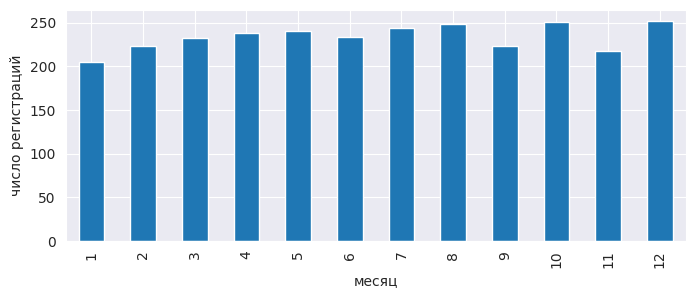

In [ ]:
reg_per_month_f.plot(x='reg_month', y='n', kind='bar', grid=True, figsize=(8,3), legend=False)
plt.xlabel('месяц')
plt.ylabel('число регистраций')
plt.show()

В первые 8 месяцев видна тенденция к росту числа мошенников. Далее процесс прекратился; в сентябре и ноябре их количество возвращалось практически к уровню января-февраля.

In [ ]:
reg_per_weekday_f = df.query('ind_frod == 1').groupby('reg_weekday').agg({'merchant_id': 'nunique'}).reset_index().rename(columns={'merchant_id': 'n'})

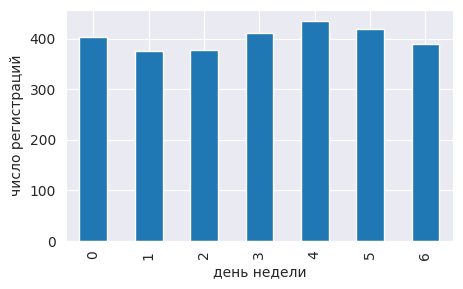

In [ ]:
reg_per_weekday_f.plot(x='reg_weekday', y='n', kind='bar', grid=True, figsize=(5,3), legend=False)
plt.xlabel('день недели')
plt.ylabel('число регистраций')
plt.show()

По вторникам и средам число регистраций мошенников ниже, чем в другие дни. А максимум приходится на пятницу.

Теперь посмотрим, в каких пропорциях делится датасет на группы активировавшихся/нет и мошенников/нет:

In [ ]:
#мошенники, которые сумели пройти регистрацию
display(act_date.query('ind_frod == 1')['merchant_id'].nunique())
display(act_date.query('ind_frod == 1')['merchant_id'].nunique() / df.shape[0])

1599

0.046880497244048316

In [ ]:
#мошенники, которые не сумели пройти регистрацию
display(no_act_date.query('ind_frod == 1')['merchant_id'].nunique())
display(no_act_date.query('ind_frod == 1')['merchant_id'].nunique() / df.shape[0])

1211

0.03550486689339744

In [ ]:
#нормальные продавцы, которые активировались
display(act_date.query('ind_frod == 0')['merchant_id'].nunique())
display(act_date.query('ind_frod == 0')['merchant_id'].nunique() / df.shape[0])

18198

0.5335405183534655

In [ ]:
#нормальные продавцы, которые отвалились на этапах регистрации
display(no_act_date.query('ind_frod == 0')['merchant_id'].nunique())
display(no_act_date.query('ind_frod == 0')['merchant_id'].nunique() / df.shape[0])

13100

0.38407411750908876

Весь датасет можно разделить на 4 группы:
  - мошенники, которые сумели пройти регистрацию (4,7%);
  - мошенники, которые не сумели пройти регистрацию (3,6%);
  - добросовестные продавцы, которые активировались (53,3%);
  - добросовестные продавцы, которые не довели процесс регистрации до конца (38,4%).
  
  Стоит обратить внимание, что очень болшой процент продавцов не проходит этап регистрации до конца. Это не является темой текущего исследования, но следовало бы пересмотреть процесс и выяснить, где проблемные места и почему так происходит.



### **Вывод**

По результатам предварительного анализа можно сделать следующие выводы:
  - исходные данные содержат id продавца, информацию о датах регистрации и активации, форму организации бизнеса (ИП или ООО), а также признак мошенника, который проставляется в ходе ручной проверки при регистрации либо уже после поступления жалоб на продавца;
  - в датасете находится информация о 35000 продавцах, начавших процедуру регистрации в период 02.01.2023 - 31.12.2023;
  - дубликатов нет;
  - удалены строки с некорректной (194 строки с неправильно указанными датами, 0,55% датасета) либо не имеющей ценности (700 строк без целевого признака мошенничества. 2% датасета) информацией; оставлено 34 108 строк (97,4% датасета);
  - сделаны следующие заключения:
    - доля продавцов-мошенников в очищенном датасете - 8,2%. Добросовестных продавцов - 91,8%;
    - в среднем в день на платформе регистрируется 96 продавцов, из них 8 мошенников;
    - в течение всего 2023 года каждый месяц регистрировалось примерно одно и то же число продавцов (2900-3000), однако число мошенников среди них росло с января (200) по август. В сентябре и ноябре количество мошенников снижалось, но октябрьский и декабрьский показатели совпадают с тем, что было в августе (250); таким образом, за год число мошенников увеличилось с 200 до 250 в месяц;
    - определенный день недели не влияет на количество регистрирующихся продавцов в общем, однако среди мошенников несколько более популярны четверг, суббота и особенно пятница;
    - средний период от регистрации до активации составляет 6 дней для обеих групп (вообще говоря, для мошенников он получился ниже - 5,9 дней против 6 для не мошенников, но различие оказалось статистически незначимым);
    - 72% продавцов оформлены как ИП, 28% - как ООО. Доля ИП среди мошенников существенно выше - 84% против 71% среди добросовестных продавцов
    - среди неактивированных клиентов доля мошенников выше на 0,38% (8,46% против 8,08%), однако различие не является статистически значимым;
    - весь датасет можно разделить на 4 группы:
      - мошенники, которые сумели пройти регистрацию (4,7%);
      - мошенники, которые не сумели пройти регистрацию (3,6%);
      - добросовестные продавцы, которые активировались (53,3%);
      - добросовестные продавцы, которые не довели процесс регистрации до конца (38,4%).
      Стоит обратить внимание, что очень большой процент продавцов не проходит этап регистрации до конца. Это не является темой текущего исследования, но следовало бы пересмотреть процесс и выяснить, где возникают проблемные места и почему так происходит.


## Ответы на вопросы и дизайн А/В-теста

Теперь ответим на вопросы задания.


### Как определить, какой продавец мошенник, а какой — нет? Какие ещё могут быть схемы мошенничества?

Начнем с описания схем мошенничества на маркетплейсах:

  1. **Продажа подделок или неисправных товаров под видом подлинных**.
  Мошенник размещает фото и описание оригинальных вещей, а отправляет подделки по цене дорогостоящих товаров. В некоторых случаях покупатель получает даже не дешевый аналог, а мусор, камни и т.п., который подложили в коробку.

  2. **Кража аккаунтов покупателей на маркетплейсе**.
  Мошенники регистрируются на площадке в качестве продавца и предлагают товар по очень привлекательной цене. После того как покупатель совершит заказ, с ним связывается продавец, и здесь схемы обмана могут варьироваться:
    - мошенники связываются с клиентами и сообщают, что оплата не прошла, после чего просят еще раз ввести данные от личного кабинета, но присылают ссылку на фишинговый сайт, который сложно отличить от реального;
    - мошенники отправляют рассылку с другими товарами и огромными скидками, а также ссылкой на оплату, по-прежнему ведущей на фишинговый сайт;
    - мошенники сообщают, что пункт доставки будет изменен, и предлагает продолжить разговор в мессенджере. Там у покупателя запрашивается код, который придет на смартфон, чтобы подтвердить смену пункта доставки. Более того, код приходит с реального номера маркетплейса, что мешает почувствовать подвох. На самом деле, узнав номер телефона покупателя, мошенники используют его в качестве логина для входа в личный кабинет на маркетплейсе, для чего в реальности и нужен запрошенный код - код подтверждения.
    
    Таким образом мошенники получают доступ к чужому аккаунту, с помощью которого можно:
    - совершить покупки за счет обманутого покупателя;
    - подать заявку на возврат денег за заказанный товар, но уже с реквизитами своей карты;
    - получить информацию о данных банковских карт, привязанных ко взломанному аккаунту.

  3. **Обманные предложения заработать, поучаствовав в "продвижении" товара**. Мошенники предлагают купить определенный товар и написать на него отзыв; обещают вернуть затраты и заплатить вознаграждение. Как правило, первые недорогие покупки действительно вознаграждаются, но после оплаты дорогостоящего товара клиент не получает ни его, ни денег.
  
  В другой похожей схеме покупателю предлагают делать заказы, а затем их отменять, объясняя это тем, что подобная активность якобы увеличивает рейтинг магазина. Оплата производится со специального счета, который принадлежит мошенникам. Покупатель вносит туда постепенно увеличивающиеся денежные суммы, а мошенники позволяют несколько раз отменить заказ и возвращают со счета стоимость товара вместе с небольшим вознаграждением. Как только жертва проникается доверием к схеме, ее просят внести более крупную сумму, после чего все контакты с мошенником обрываются.

  В некоторых случаях покупателю, готовому оставлять отзывы за деньги или покупать и возвращать товары, сообщают, что он принят на работу и необходимо зарегистрироваться по ссылке от "куратора". Такая ссылка вновь ведет на фишинговый сайт, где клиент оствляет персональную информацию и данные о карте, чтобы получать на нее "зарплату". Первое время небольшие суммы даже могут переводиться, но в итоге все сводится к краже денег с карты.

  4. **Фальшивая техподдержка**. Мошенники выискивают в соцсетях клиентов, которые оставляют жалобы на работу маркетплейса, в частности на некорректно списанные суммы комиссий. Под видом официальных представителей службы поддержки площадки они свзываются с покупателем и предлагают компенсировать ущерб, вернув на карту излишне удержанные деньги, после чего присылают специальную форму для ввода реквизитов. Форма возврата ведет на поддельную страницу банка, а мошенники получают всю информацию о карте.


Задача определения продавцов-мошенников разбивается на два этапа:
  - выявить на этапе регистрации и не допустить до продажи товаров;
  - выявить среди активированных продавцов.

На этапах регистрации флагами могут быть следующие моменты. Часть мошенников регистрируется под названием и ИНН уже существующей компании/ИП, часть - создают фирму-однодневку. В любом случае маркетплейс должны насторожить:
  - признаки подделки документов (учредительных, паспорта и пр.), прикрепляемых к заявке на регистрацию;
  - запись в ЕГРЮЛ о недействительности ЮЛ/ИП;
  - подозрительные контактные данные (некоторые мошенники создают временные электронные адреса, которые самоуничтожаются через определенный промежуток времени. Очевидно, реальный продавец так делать не будет. Таким образом, можно отлавливать мошенников по подозрительному e-mail (@mfyax.com, @gufum.com и др.));
  - ряд признаков, характерных для компаний-однодневок (выявляются с помощью сервисов для проверки контрагентов типа СПАРК Интерфакс, Контур.Фокус и др. : минимальный размер уставного капитала, частая смена генеральных директоров, нулевая или не сданная в ФНС отчетность, большое количество кодов ОКВЭД, отсутствие сайта, рекламы, недействительный юридический адрес и т.п.;
  - небольшое количество товаров для продажи (может говорить о том, что реальных намерений работать на площадке нет);

 Если же мошенник усепешно прошел все этапы регистрации и начал работать, привлечь к нему внимание могут следующие факторы:
  -  жалобы в поддержку от покупателей на недобросовестные действия Рассматривать метрику лучше и в абсолютном (общее количество), и в относительном выражении (число жалоб по отношению ко всем заказам), ведь у крупных поставщиков неизбежно будет больше ошибок в работе, необязательно вызванных мошенническими действиями;
  - негативные отзывы на продавца. Похоже на жалобы, однако стоит иметь в виду, что они могут быть сфальсифицированы, например, конкурентами, чтобы убрать продавца с площадки;
  - по различным уловкам продавца связаться с покупателем в обход площадки: ссылки на другие сайты, номера телефонов. аккаунты в мессенджерах и социальных сетях. Это не обязательно будет характеризовать его как мошенника, поскольку многие собирают контакты для своих баз, например, для рассылки рекламы или для других вполне законных целей. Вместе с тем практически все мошеннические схемы начинются с попыток заполучить контактные данные покупателя. Общение в личном кабинете на Мегамаркете не предусмотрено, однако продавец может отвечать на вопросы о товарах, что увидят все покупатели, а также указать информацию при заполнении карточек товаров. Несмотря на то, что на маркетплейсе есть проверка и ответов на вопросы, и карточек, не стоит недооценивать способности мошенников;
  - комбинация косвенных признаков, указывающих на мошенничество:
    - подозрительно низкая цена, особенно в сочетнии с бонусами;
    - недавняя дата регистрации магазина;
    - стопроцентная предоплата;
    - доставка курьером продавца.
  
  
  
  






### Какие продуктовые фичи могут помочь клиентам избежать неприятных ситуаций с мошенничеством?

1. **Сигнал покупателям о том, что цена существенно ниже средней**

Первая причина, из-за которой пользователи попадаются в ловушку мошенников, - это желание существенно сэкономить. Мошенники предлагают приобрести дорогостоящий товар чуть ли не вдвое дешевле, чем в других магазинах. Для обычных продавцов это очень невыгодно. Если маркетплейс будет сигнализировать покупателю, просматривающему такие предложения, о том, что настолько низкая цена не соответствует рынку и подозрительна, возможно, часть из них не станет рисковать. Информацию о средней цене маркетплейс может агрегировать со своей же площадки либо ориентироваться еще и на другие маркетплейсы.

2. **Рейтинг благонадежности от маркетплейса**

Наряду с рейтингом от покупателей, который бывает накручен, маркетплейс может по характерным для мошенников признакам выставить и свою взвешенную оценку. В качестве критериев можно использовать косвенные признаки мошенничества, перечисленные в предыдущем разделе: срок работы на площадке, качество заполнения карточек, соответствие продаваемым товарам кодов ОКВЭД, способ доставки, действительность юридического адрес, процент отмены заказов и пр.

3. **Оценка достоверности отзывов**

Когда пользователь принимает решение о покупке у того или иного продавца, он опирается в том числе и на отзывы других покупателей. Мошенники часто прибегают к публикации фальшивых отзывов о своем товаре, причем для недавно зарегистрированного магазина важно опубликовать большое их количество за короткое время. Несмотря на формальное прохождение модерации, заметно, что многие из них сгенерированы нейросетями. Можно было бы внедрить систему, которая оценивает качество отзывов, учитывает скорость публикации и дает ответ, насколько отзывы достоверны.


4. **Создание системы оповещений о мошенничестве**

Какими бы надежными ни были способы распознавания мошенников у площадок, конечной целью мошенников является обман конкретного покупателя. И именно от доверчивости и поведения покупателя зависит, попадется он на удочку или нет. На интернет-площадках, в социальных сетях постоянно пишут обманутые пользователи, хотя указанные ими схемы мошенничества могут применяться уже довольно давно. Маркетплейсы могли бы снизить число пострадавших, если бы в превентивных целях чаще и больше распространяли информацию о способах обмана. Это может быть сделано, например, в виде обязательного теста при регистрации покупателя, еженедельных рассылок о новых схемах, мини-игры и пр.



### Через какую механику мошенник узнает контакты покупателя? Что можно сделать, чтобы усложнить жизнь фродерам?

Когда покупатель оформляет заказ, продавцу передаются его данные, в том числе и контакты для связи. Даже после отмены заказа информация остается на стороне продавца. Дальше мошенникам обычно не составляет труда найти покупателя в мессенджерах и обратиться к нему за пределами площадки.

В том случае, когда заказ был отменен по вине продавца, можно направлять покупателю предупреждение с кратким описанием схемы мошенничества и призывом к осторожности, если за пределами площадки продавец начнет предлагать заказать тот же товар по такой же или еще более низкой цене.

Можно блокировать аккаунт продавца до окончания разбирательства, если доля отмененных по вине продавца заказов начинает превышать определенное значение.

Встречается и такая схема обмана: продавец присылает покупателю поддельный товар, а чтобы тот не сумел оставить отрицательный отзыв, удаляет карточку товара и создает похожую на нее новую. Поскольку пострадавший может оставить отзыв только на тот товар, который купил, с разоблачением мошенника возникнут сложности. В таких случаях маркетплейс мог бы отслеживать подозрительные активности при смене карточек товара и приостанавливать работу аккаунта до выяснения обстоятельств.

Мегамаркет входит в один холдинг со Сбером - крупнейшим банком в России. Многие физические и юридические лица были или являются его клиентами. Таким образом, репутацию некоторых продавцов Мегамаркета можно было бы проверить еще на этапе регистрации. Если продавец совершал сомнительные операции в банке, то это может быть сигналом, что и на маркетплейсе он не будет соблюдать правила.

Также в глобальном плане одним из возможных действий по препятствию недобросовестным продавцам может быть создание структуры, которая бы объединяла информацию о мошенниках с разных маркетплейсов, по аналогии с тем, как это сделано в банках: ООО и ИП, несколько раз уличенные в сомнительных операциях, больше не имеют возможности полноценно работать по расчетным счетам ни в одном банке, соблюдающем рекомендации Росфинмониторинга и ЦБ.


### Методология и дизайн теста. Основная метрика и принцип разделения на группы. Расчет MDE

Итак, **проблема**, которую обозначает маркетплейс, - это успешная регистрация продавцов-мошенников на площадке. В настоящий момент признак неблагонадежного продавца проставляется в ходе ручной проверки при регистрации либо уже после поступления жалоб на продавца.

ML-команда предлагает внедрить в процесс регистрации модель автоматического определения продацов-мошенников. Ее цель - обнаружить максимальное количество фродеров на этапе регистрации.

С помощью **А/Б-теста** предлагается проверить качество и функциональность модели.

**Гипотеза**, которую будем проверять в ходе теста, заключается в следующем: новая модель снизит количество продавцов-мошенников, которые смогут пройти регистрацию на площадке.

В качестве **ключевой метрики** выберем отношение количества продавцов-мошенников, прошедших все этапы регистрации и активировавшихся, к общему количеству активированных продавцов за определенный период.

**Барьерной метрикой** будет количество ежедневных регистраций продавцов. Если модель применяет слишком жесткие критерии и часто ошибается, блокируя еще и добросовестных продавцов, они не смогут пройти этап регистрации и уйдут на другие площадки, что приведет к потере выручки и прибыли маркетплейса.

За **прокси-метрику** возьмем ежедневную долю жалоб, приходящихся на одного продавца: если новая модель работает эффективно и фильтрует мошенников на этапе регистрации, это в первую очередь скажется на количестве негативных обращений от покупателей.

В качестве метода тестирования будем использовать **односторонний Z-тест для двух пропорций**. Для него требуется, чтобы выборки из генеральной совокупности были случайны и независимы (о разделении на группы поговорим далее). Распределение z-статистики стремится к нормальному закону при больших объемах выборок, что позволяет использовать таблицу с критическими значениями стандартного нормального распределения. Для того чтобы принять решение, отвергнуть Н0 или нет, необходимо знать размер выборок, число "успешных" исходов в обеих группах (в нашем случае - количество найденных мошенников), а также уровень статистической значимости.

В качестве **уровня значимости** и **мощности теста** выберем традиционные значения - 0,05 и 80% соответственно.

Основываясь на данных за 2023 год, мы знаем, что в среднем в день регистрируется 96 продавцов, среднее число активаций 53,6, среднее число мошеннических активаций - 4,3 (8%). Разделять новых продавцов необходимо пополам случайным образом на две группы - тестовую и контрольную - так, чтобы выборки были стратифицированы. В нашем случае это означает, что в них соблюдаются максимально возможно близкие пропорции по следующим признакам:
  - форма организации бизнеса (ООО или ИП);
  - время с момента регистрации бизнеса;
  - географический регион.





Рассчитаем **MDE**. Для этого нам понадобятся уровень значимости, мощность, а также размер выборки.

Размер выборки можно определить, имея представление о продолжительности теста. По условию задачи эта информация не дана. Предположим, что у нас есть возможность продолжать тест три недели.

Посмотрим на распределение выбранной метрики:




In [ ]:
n_act = act_date.query('activation_date <= "2023-12-01"').groupby('activation_date').agg({'merchant_id':'nunique'}).reset_index().rename(columns = {'merchant_id': 'num_total'})
n_act_f = act_date.query('activation_date <= "2023-12-01" & ind_frod == 1').groupby('activation_date').agg({'merchant_id':'nunique'}).reset_index().rename(columns = {'merchant_id': 'num_fraud'})

График, показывающий динамику общего числа активаций в день и числа активирующихся мошенников:

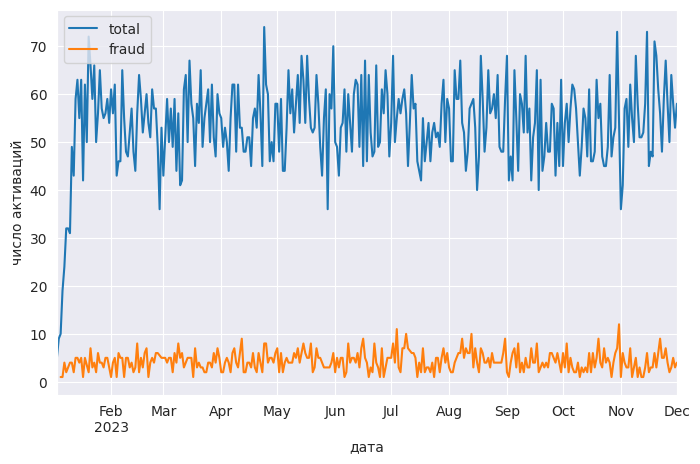

In [ ]:
ax = n_act.plot(x='activation_date', y='num_total', grid=True, figsize=(8,5), label='total')
n_act_f.plot(ax=ax, x='activation_date', y='num_fraud', grid=True, figsize=(8,5), label='fraud')
plt.xlabel('дата')
plt.ylabel('число активаций')
plt.show()

Среднее и медианное число активирующихся продавцов и мошенников в частности:

In [ ]:
n_act['num_total'].agg(['mean','median'])

mean      53.645646
median    54.000000
Name: num_total, dtype: float64

In [ ]:
n_act_f['num_fraud'].agg(['mean','median'])

mean      4.336391
median    4.000000
Name: num_fraud, dtype: float64

In [ ]:
n_act_f['num_fraud'].mean() / n_act['num_total'].mean()

0.0808339872718234

In [ ]:
act_by_date = n_act.merge(n_act_f, on='activation_date')
act_by_date['fraud_share'] = act_by_date['num_fraud'] / act_by_date['num_total']

График и статистики ключевой метрики:

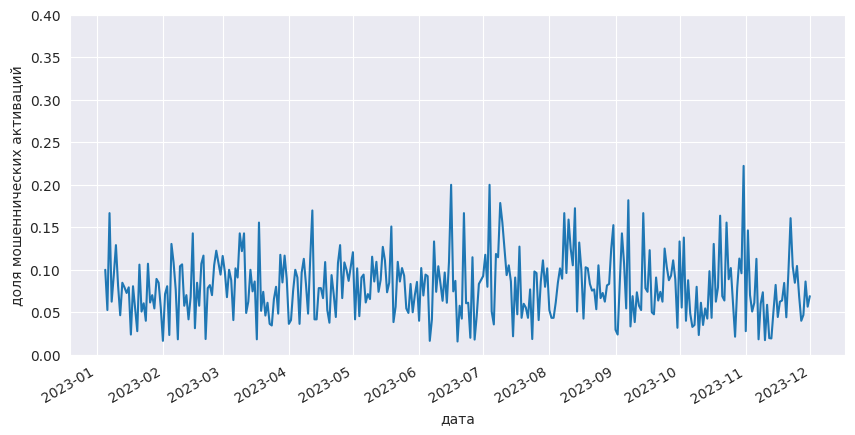

In [ ]:
act_by_date.plot(x='activation_date', y='fraud_share', ylim=(0,0.4), grid=True, figsize=(10,5), legend=False)
plt.xlabel('дата')
plt.ylabel('доля мошеннических активаций')
plt.show()

In [ ]:
act_by_date['fraud_share'].describe()

count    327.000000
mean       0.080693
std        0.037181
min        0.015625
25%        0.052632
50%        0.079365
75%        0.102041
max        0.222222
Name: fraud_share, dtype: float64

Рассчитаем MDE.

Размер выборок известен: 54 * 21 / 2 = 567 продавцов. Среднее значение и стандартное отклонение выбранной метрики составляют 0,08 и 0,03 соответственно. Z-значения для заданных alpha и beta также определяются.
Получаем, что MDE = 0,068 = 6,8%.

In [ ]:
std = act_by_date['fraud_share'].std()
m = act_by_date['fraud_share'].mean()
alpha = 0.05
beta = 0.8
n = 567
z1 = stats.norm.ppf(1 - alpha)
z2 = stats.norm.ppf(1 - beta)
mde = mth.sqrt(2) * std * (z1 - z2) / (m * mth.sqrt(n))

In [ ]:
mde

0.06804404849178713